In [1]:
import copy
import os.path
import torch
import torch.functional as F
import math
import logging
import numpy as np
import PIL.Image    
import exiftool
import cv2
import ultralytics
from shapely.geometry import Polygon
from flat_bug.ml_utils import iou_match_pairs, iou
from flat_bug.geometry_simples import contours_to_masks
from ultralytics import YOLO
from ultralytics.nn.tasks import SegmentationModel
from ultralytics.nn.autobackend import AutoBackend
from ultralytics.models.yolo.segment import SegmentationPredictor
from ultralytics.engine.results import Results
from ultralytics.utils import ops

from torchvision.io import read_image
import torchvision.transforms as transforms

from tqdm import tqdm

import logging
import os
from flat_bug.predictor import Predictor
from pyremotedata.implicit_mount import *
from pyremotedata.dataloader import *

import matplotlib.pyplot as plt
import matplotlib as mpl

import itertools

from src.flat_bug.predictor import *
from src.flat_bug.yolo_helpers import *

In [2]:
from glob import glob
from random import sample

seed = 42

datasets = {p.removeprefix("s3/") : glob(f'{p}/**.jpg') for p in glob("s3/**")}

# sds = sample(list(datasets.keys()), 1)[0]
sds = "pitfall"
paths = sample(datasets[sds], 5)

weights = "last.pt"
device = torch.device("cpu")
dtype = torch.float32

images = [read_image(p).to(device, dtype) for p in paths]
# image = resize(image)s
resize = transforms.Resize((1024, 1024))

_model = Predictor(weights, device=device, dtype=dtype)
_model.MINIMUM_TILE_OVERLAP = 384
_model.SCORE_THRESHOLD = 0.2
_model.MAX_MASK_SIZE = 512
_model.IOU_THRESHOLD = .1
_model.MIN_MAX_OBJ_SIZE = 1, 2048
_model.TIME = False

Transferred 537/537 items from pretrained weights


In [6]:
start = time.time()
for i in range(len(images)):
    print(i)
    test = _model.pyramid_predictions(images[i], paths[i], scale_increment=3/4, scale_before=1/2)
    test.save("dev/output", fast=True, crops = False)
print(f'Average time: {(time.time() - start) / len(images):.3f}s')

tensor([[ 504.6855, 1563.6216,  574.1312, 1626.4272],
        [ 531.1400, 1345.3440,  589.3744, 1477.6194],
        [ 834.0190, 1368.3143,  880.5808, 1416.9469],
        [ 715.9625, 1529.0000,  765.9799, 1576.4565],
        [ 825.1123, 1492.3826,  878.3329, 1530.8516],
        [ 913.3086, 1341.2012,  936.1062, 1389.7251],
        [ 713.1553, 1402.9221,  744.8132, 1441.7710],
        [ 438.9873, 1342.3472,  460.4488, 1386.9429],
        [1157.6802, 1001.1584, 1271.4062, 1184.9121],
        [1298.9276, 1271.1134, 1398.1809, 1436.3376],
        [ 949.9135, 1023.7762, 1021.4180, 1124.6055],
        [1072.2079, 1134.9167, 1134.2831, 1248.1904],
        [1186.4783, 1486.1993, 1225.1470, 1572.3282],
        [1007.1434, 1372.6157, 1065.1228, 1417.9360],
        [ 833.9545, 1368.3079,  880.6602, 1417.1525],
        [ 825.0485, 1492.1558,  878.4196, 1531.0752],
        [ 716.0277, 1529.0203,  765.9471, 1576.4590],
        [ 913.0668, 1341.0009,  936.2971, 1389.6613],
        [ 713.1055, 1402.946

In [4]:
test.boxes

tensor([[1378, 1070, 1669, 1523],
        [1607, 1850, 1689, 1984],
        [1828, 1533, 2026, 1740],
        [ 534, 1432,  797, 1722],
        [ 698, 2394,  842, 2648],
        [ 299, 1832,  562, 2262],
        [1704, 1236, 1830, 1329],
        [1462, 1763, 1526, 1874],
        [1659, 3141, 1898, 3284],
        [ 910, 2832, 1008, 2951],
        [2194, 2475, 2341, 2587],
        [1714, 2864, 1838, 3036],
        [1218, 2875, 1404, 2989],
        [1217, 3038, 1365, 3150],
        [2173, 2787, 2266, 2915]])

In [15]:
test_loaded = TensorPredictions().load("test/original_20220730023959-130-snapshot/original_20220730023959-130-snapshot.json")
test_loaded.image = test.image

# test_loaded.plot_torch(outpath="test/test.jpg", linewidth=1, scale=1/2)
test_loaded.plot_opencv(outpath="test/test_loaded.jpg", linewidth=2, scale=1)
test.plot_opencv(outpath="test/test.jpg", linewidth=2, scale=1)

Text(0.5, 1.0, 'IoS * IoU')

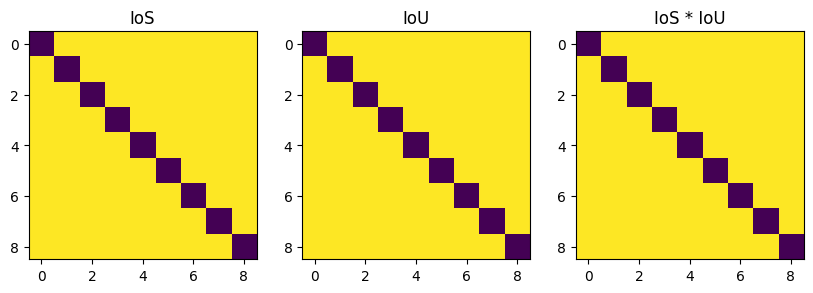

In [6]:
from flat_bug.yolo_helpers import ios_masks_2sets, iou_masks_2sets, nms_masks

ios_mat = torch.cat([ios_masks_2sets(m, test.masks.data, dtype=dtype) for m in test.masks.data])
iou_mat = torch.cat([iou_masks_2sets(m, test.masks.data, dtype=dtype) for m in test.masks.data])

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow((ios_mat < _model.IOU_THRESHOLD).cpu().numpy())
axs[0].set_title("IoS")
axs[1].imshow((iou_mat < _model.IOU_THRESHOLD).cpu().numpy())
axs[1].set_title("IoU")
axs[2].imshow((ios_mat * iou_mat < _model.IOU_THRESHOLD).cpu().numpy())
axs[2].set_title("IoS * IoU")

In [ ]:
def expand_with_neighbors(indices, mx, my):
    # Initialize a list to store the expanded indices
    expanded_indices = []

    # Define the relative positions of the neighbors
    neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]

    # Iterate over each index pair and add its neighbors
    for x, y in indices:
        for dx, dy in neighbors:
            new_x, new_y = x + dx, y + dy
            new_x = min(max(new_x, 0), mx)
            new_y = min(max(new_y, 0), my)
            expanded_indices.append([new_x, new_y])

    # Convert the list of indices to a numpy array
    return np.array(expanded_indices)


In [ ]:
plt.figure(figsize=(10, 10))
ms = np.zeros(image.shape[1:]) # CxHxW
boxes = test._bboxes # x, y, w, h
print(ms.shape)
xys = np.concatenate(test.contours)
msx, msy = ms.shape
xys = expand_with_neighbors(expand_with_neighbors(xys, msy - 1, msx - 1), msy - 1, msx - 1)
ms[xys[:, 1], xys[:, 0]] = 1
# Permute to HxWxC (numpy)
# ms = ms.transpose(1, 2, 0)
plt.imshow(image.cpu().int().permute(1, 2, 0))
# plt.imshow(ms, alpha = .75)
for x, y, w, h in boxes:
    plt.gca().add_patch(mpl.patches.Rectangle((x, y), w, h, fill=False, edgecolor='r', linewidth=1))
plt.show()

In [168]:
# def intersect_test(rect1, rect2s, area_only=False, debug=False):
#     """
#     Calculates the intersection of a rectangle with a set of rectangles.
#     """
#     if len(rect1.shape) == 1 and not rect1.shape[0] == 4 or len(rect1.shape) == 2 and not rect1.shape[1] == 4:
#         raise ValueError(f"Rectangles must be of shape (n, 4), not {rect1.shape}")
#     if len(rect2s.shape) == 1 and not rect2s.shape[0] == 4 or len(rect2s.shape) == 2 and not rect2s.shape[1] == 4:
#         raise ValueError(f"Rectangles must be of shape (n, 4), not {rect2s.shape}")
#     if len(rect1.shape) == 1:
#         rect1 = rect1.unsqueeze(0)
#     if len(rect2s.shape) == 1:
#         rect2s = rect2s.unsqueeze(0)

#     # Safer to enable this, but it is slower
#     # # Check the validity of the rectangles
#     # if not check_bltr_validity(rect1, debug):
#     #     rect1 = fix2btlr(rect1)
#     # if not check_bltr_validity(rect2s, debug):
#     #     rect2s = fix2btlr(rect2s)

#     # Calculate vectors from each corner of rect1 to each corner of rect2s
#     blbltrtr = rect2s - rect1
#     bl_to_bl = blbltrtr[:, :2]
#     tr_to_tr = blbltrtr[:, 2:] 
#     bltrtrbl = rect2s[:, [2, 3, 0, 1]] - rect1
#     bl_to_tr = bltrtrbl[:, :2]
#     tr_to_bl = bltrtrbl[:, 2:]
    
#     # Determine if each corner of rect1 is inside each rect2
#     inside_tr = (tr_to_tr[:, 0] >= 0) & (tr_to_tr[:, 1] >= 0) & (tr_to_bl[:, 0] <= 0) & (tr_to_bl[:, 1] <= 0)
#     inside_bl = (bl_to_bl[:, 0] <= 0) & (bl_to_bl[:, 1] <= 0) & (bl_to_tr[:, 0] >= 0) & (bl_to_tr[:, 1] >= 0)
#     inside_tl = (bl_to_bl[:, 0] <= 0) & (tr_to_tr[:, 1] >= 0) & (bl_to_tr[:, 0] >= 0) & (tr_to_bl[:, 1] <= 0)
#     inside_br = (tr_to_tr[:, 0] >= 0) & (bl_to_bl[:, 1] <= 0) & (tr_to_bl[:, 0] <= 0) & (bl_to_tr[:, 1] >= 0)

#     # Check for enclosure
#     enclosure = (rect1[:, :2] <= rect2s[:, :2]) & (rect1[:, 2:] >= rect2s[:, 2:])

#     # Check for intersection with the "infinitely" extended cross of rect1
#     in_cross = ((bl_to_bl[:, 0] <= 0) & (bl_to_tr[:, 0] >= 0)) | ((tr_to_tr[:, 0] >= 0) & (tr_to_bl[:, 0] <= 0)), ((bl_to_bl[:, 1] <= 0) & (bl_to_tr[:, 1] >= 0)) | ((tr_to_tr[:, 1] >= 0) & (tr_to_bl[:, 1] <= 0))

#     # Check for equality - if equal, return the original rectangles
#     zero = torch.tensor(0, dtype=rect1.dtype, device=rect1.device)
#     is_equal = (bl_to_bl.isclose(zero).all(dim=1)) & (tr_to_tr.isclose(zero).all(dim=1))

#     # Check for no intersection - if no intersection, return the intersection rectangle [0, 0, 0, 0]
#     is_intersecting = inside_tl | inside_br | inside_bl | inside_tr | (enclosure[:, 0] & in_cross[1]) | (enclosure[:, 1] & in_cross[0]) | (enclosure[:, 0] & enclosure[:, 1]) | is_equal

#     if not area_only:
#         intersections = is_intersecting.unsqueeze(1) * torch.cat((torch.max(rect1[:, :2], rect2s[:, :2]), torch.min(rect1[:, 2:], rect2s[:, 2:])), dim=1)
#         intersections[is_equal] = rect1
#     else:
#         intersections = torch.zeros(rect2s.shape[0], dtype=rect1.dtype, device=rect1.device)
#         intersections[is_intersecting] = (torch.min(rect1[:, 2:], rect2s[is_intersecting, 2:]) - torch.max(rect1[:, :2], rect2s[is_intersecting, :2])).abs().prod(dim=1)

#     if debug:
#         # Used for debugging
#         return intersections, torch.stack((inside_tl, inside_tr, inside_br, inside_bl), dim=1), enclosure, in_cross
#     else:
#         return intersections

def intersect_test(rect1, rect2s, **kwargs):
    # This implementation apparently gets the intersection area of two rectangles, perhaps it can be used to get the intersection rectangle as well
    # (b1_x2.minimum(b2_x2) - b1_x1.maximum(b2_x1)).clamp_(0) \
    #     * \
    # (b1_y2.minimum(b2_y2) - b1_y1.maximum(b2_y1)).clamp_(0)
    # Rectangles are formatted as xmin, ymin, xmax, ymax
    def _inter1(b1, b2):
        b1_x1, b1_y1, b1_x2, b1_y2 = b1
        b2_x1, b2_y1, b2_x2, b2_y2 = b2

        ix1 = max(b1_x1, b2_x1)
        iy1 = max(b1_y1, b2_y1)
        ix2 = min(b1_x2, b2_x2)
        iy2 = min(b1_y2, b2_y2)

        # Check for no intersection
        if ix2 < ix1 or iy2 < iy1:
            return 0, 0, 0, 0
        
        return ix1, iy1, ix2, iy2
    
    def _inter2(b1, b2):
        """
        This time b1 and b2 are tensors
        """
        # Get the maximum of the minimum x and y values, to do this in a vectorized way we negate x1 and y1 and take the minimum, then negate the result. 
        b1[:2] *= -1
        b2[:2] *= -1
        i = torch.min(b1, b2)
        i[:2] *= -1
        b1[:2] *= -1
        b2[:2] *= -1
        # Check for no intersection
        return i * (~(i[2:] < i[:2]).any())
    
    def _inter3(b1, b2s):
        """
        Now b2s is a tensor of rectangles
        """
        ix_max = torch.max(b1[:2].unsqueeze(0), b2s[:, :2])
        ix_min = torch.min(b1[2:].unsqueeze(0), b2s[:, 2:])
        ix = torch.zeros_like(b2s)
        ix[:, :2] = ix_max
        ix[:, 2:] = ix_min
        # Check for no intersection
        ix[(ix_min < ix_max).any(dim=1)] = 0
        return ix
    
    def _inter4(b1, b2s):
        """
        Now vectorized, but with NumPy
        """
        ix_max = np.maximum(b1[:2], b2s[:, :2])
        ix_min = np.minimum(b1[2:], b2s[:, 2:])
        ix = np.zeros_like(b2s)
        ix[:, :2] = ix_max
        ix[:, 2:] = ix_min
        # Check for no intersection
        ix[(ix_min < ix_max).any(axis=1)] = 0
        return ix
    
    N = rect2s.shape[0]
    rect1 = rect1[0]
    _dtype, _device = rect1.dtype, rect1.device

    start = time.time()
    intersections_1 = torch.tensor([_inter1(rect1.tolist(), rect2.tolist()) for rect2 in rect2s], dtype=_dtype, device=_device)
    t1 = time.time() - start
    # print(f"Time for native Python: {t1:.3f}s")
    start = time.time()
    intersections_2 = torch.stack([_inter2(rect1, rect2) for rect2 in rect2s])
    t2 = time.time() - start
    # print(f"Time for PyTorch: {t2:.3f}s")
    start = time.time()
    intersections_3 = _inter3(rect1, rect2s)
    t3 = time.time() - start
    # print(f"Time for vectorized PyTorch: {t3:.3f}s")
    rect1 = rect1.numpy()
    rect2s = rect2s.numpy()
    start = time.time()
    intersections_4 = _inter4(rect1, rect2s)
    t4 = time.time() - start
    # print(f"Time for vectorized NumPy: {t4:.3f}s")

    # Check for correctnesss
    if not torch.all(intersections_1 == intersections_2):
        print("Error in _inter1 and _inter2")
    if not torch.all(intersections_1 == intersections_3):
        print("Error in _inter1 and _inter3")
    if not torch.all(intersections_1 == torch.tensor(intersections_4, dtype=_dtype, device=_device)):
        print("Error in _inter1 and _inter4")

    return t1, t2, t3, t4
    # return intersections_3, torch.zeros((N, 4)), torch.zeros((N, 2)), (torch.zeros(N) == 0, torch.zeros(N) == 0)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:19<00:00,  1.67s/it]


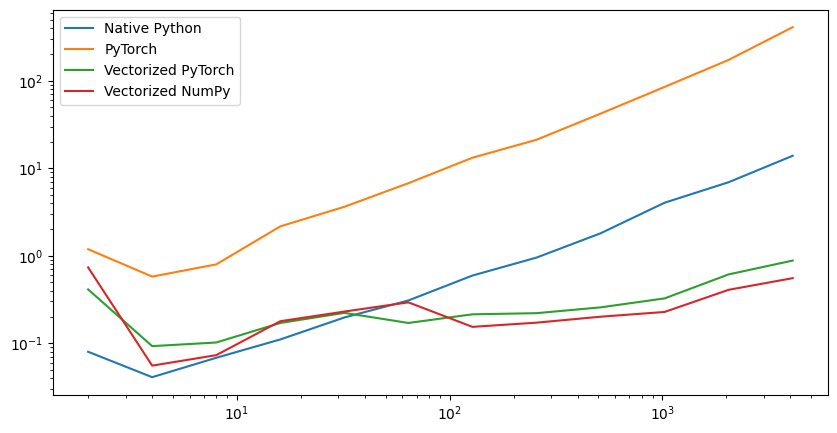

In [169]:
r1 = torch.tensor([2, 2, 5, 5], dtype=torch.uint8, device=device)  # Rectangle 2 coordinates

number_of_rectangles = 2 ** torch.arange(1, 13)

times = torch.zeros((4, len(number_of_rectangles)))

for i, n in tqdm(enumerate(number_of_rectangles), total = len(number_of_rectangles)):
    r2s = torch.randint(0, 255, (n, 4), dtype=torch.int16, device=device)

    times[:, i] = torch.tensor([intersect_test(r1.unsqueeze(0), r2s) for _ in range(25)]).mean(dim=0) * 1000

plt.figure(figsize=(10, 5))

plt.plot(number_of_rectangles, times[0], label="Native Python")
plt.plot(number_of_rectangles, times[1], label="PyTorch")
plt.plot(number_of_rectangles, times[2], label="Vectorized PyTorch")
plt.plot(number_of_rectangles, times[3], label="Vectorized NumPy")

plt.gca().set_yscale("log")
plt.gca().set_xscale("log")

plt.legend()
plt.show()

In [84]:
# Example usage
r2 = torch.tensor([2, 2, 5, 5], dtype=torch.int16, device=device)  # Rectangle 2 coordinates

xmins = [1, 2]
ymins = [1, 2]
xmaxs = [4, 5]
ymaxs = [4, 5]
# xmins = [1, 3]
# ymins = [1, 3]
# xmaxs = [4, 6]
# ymaxs = [4, 6]

# n_rects = len(xmins) * len(ymins) * len(xmaxs) * len(ymaxs)
# ncols = min(6, int(n_rects ** (1/2)))
# nrows = math.ceil(n_rects / ncols)

# fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))

rectangles = []

for xmin, ymin, xmax, ymax in itertools.product(xmins, ymins, xmaxs, ymaxs):
    r11 = torch.tensor([xmin, ymin, xmax, ymax], dtype=r2.dtype, device=device)
    rectangles.append(r11.clone())

rectangles = torch.stack(rectangles)
rectangles = fix2btlr(rectangles)

intersections, corners, encs, crs = intersect_test(r2.unsqueeze(0), rectangles, debug=True)

# # Move tensors to cpu and convert to float
# rectangles = rectangles.detach().float().cpu().numpy()
# intersections = intersections.detach().float().cpu().numpy()
# corners = corners.detach().cpu()
# encs = encs.detach().cpu()
# crs = torch.stack(crs, dim=1).detach().cpu()
# r2 = r2.detach().float().cpu().numpy()

# for i, (ax, r1, inter) in enumerate(zip(axs.flatten(), rectangles, intersections)):
#     # IOU
#     a1 = (r1[2] - r1[0]) * (r1[3] - r1[1])
#     a2 = (r2[2] - r2[0]) * (r2[3] - r2[1])
#     ai = (inter[2] - inter[0]) * (inter[3] - inter[1])
#     iou = ai / (a1 + a2 - ai)

#     # Plot rect1
#     p1 = mpl.patches.Rectangle((r1[0], r1[1]), r1[2] - r1[0], r1[3] - r1[1], linewidth=3, edgecolor="r", facecolor="none", alpha=1)
#     # Plot rect2
#     p2 = mpl.patches.Rectangle((r2[0], r2[1]), r2[2] - r2[0], r2[3] - r2[1], linewidth=3, edgecolor="b", facecolor="none", alpha=1)

#     # Plot the intersection
#     if inter.sum() > 0:
#         p3 = mpl.patches.Rectangle((inter[0], inter[1]), inter[2] - inter[0], inter[3] - inter[1], linewidth=0, edgecolor="none", facecolor="g", alpha=0.5)
#         ax.add_patch(p3)
#         icenter = (inter[2:] + inter[:2]) / 2
#         ax.text(icenter[0], icenter[1], f"{iou:.2f}", color="g", fontsize=12, ha="center", va="center")
#     ax.add_patch(p1)
#     ax.add_patch(p2)

#     ax.set_xlim([0, 8])
#     ax.set_ylim([0, 8])
#     # ax.set_xticks([])
#     # ax.set_yticks([])
#     ax.set_title("i: " + str(i) + " | co: " + ",".join(["T" if c.item() else "F" for c in corners[i]]) + " | en: " +  ",".join(["T" if e.item() else "F" for e in encs[i]]) + " | cr: " +  ",".join(["T" if c.item() else "F" for c in crs[i]]), fontsize=11)

# plt.tight_layout()
# plt.show()


Time for native Python: 0.000s
Time for PyTorch: 0.004s
Time for vectorized PyTorch: 0.000s
Time for vectorized NumPy: 0.000s
